In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from geopy.distance import geodesic
from quetzal.model import stepmodel
from quetzal.analysis import analysis
from quetzal.engine.pathfinder import PublicPathFinder
from quetzal.io.display import all_pt_paths

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the LoS tables
## Saves a StepModel with shortest paths and LoS attributes for the PT network
## Needs aggregated PT networks

In [2]:
input_path = '../input/'
output_path = '../output/'
model_path = '../model/'

In [3]:
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')
ae = stepmodel.read_json(model_path + 'de_pt_access_egress')
aux = stepmodel.read_json(model_path + 'de_pt_network_ancillary')

In [4]:
sm.centroids = ae.centroids
sm.footpaths = ae.footpaths
sm.zone_to_transit = ae.zone_to_transit

In [5]:
sm.links.shape

(199294, 9)

### Prepare links for pathfinder

In [6]:
# Generate headways (two times the waiting time at a stop when changing between trips)
# ASSUMPTION: Take average headways for core hours between 6 a.m. and 8 p.m.
freq = aux.frequencies.loc[(aux.frequencies['hour']>=6) &
                           (aux.frequencies['hour']<=19)
                          ].groupby('stop_id').agg({'trip_id': 'sum'})
freq['trip_id'] = 14*3600 / freq['trip_id'] # 14 hours

In [7]:
headway_dict = freq['trip_id'].to_dict()

In [8]:
# ASSUMPTION: Maximum waiting time is 20 minutes, minumum is 5 minutes
sm.links['headway'] = sm.links['a'].map(headway_dict)
sm.links['headway'] = sm.links['headway'].replace(
    {np.nan: 15*60*2}).clip(lower=5*60*2, upper=20*60*2)

In [9]:
# ASSUMPTION: Air trips require security checks and so on...
sm.links.loc[sm.links['route_type']=='air', 'headway'] = 45*60*2
sm.links['headway'] = sm.links['headway'].astype(int)

<AxesSubplot:>

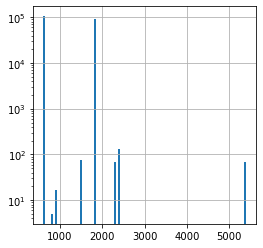

In [10]:
sm.links['headway'].hist(bins=100, figsize=(4,4), log=True)

In [11]:
# Reset access/egress time to zero
# Because it should not be a mode choice decision factor.
# LoS attribute accessibility will handle this.
#sm.zone_to_transit['time'] = 0

In [12]:
# Generate length for PT links as the crow flies
if 'length' not in sm.links.columns:
    tqdm.pandas()
    sm.links['length'] = sm.links['geometry'].progress_apply(
        lambda l: int(geodesic(l.coords[0], l.coords[-1]).m))

In [13]:
sm.links.sample()

,a,b,length,route_type,geometry,link_sequence,route_id,time,trip_id,headway
index,,,,,,,,,,
bus_926419,DE922_bus_0,DE922_bus_1,39928,bus,"LINESTRING (8.55176 52.62632, 8.85473 52.82363)",1,bus_826,480,bus_147121,600


In [14]:
# Load OD pairs from volumes if available
od_set = None
try:
    v = stepmodel.read_json(model_path + 'de_volumes')
    od_set = set([tuple(l) for l in v.volumes[['origin', 'destination']].values.tolist()])
    print('Generated OD set with {} pairs'.format(len(od_set)))
except:
    print('The volumes file is not (yet) available')

Generated OD set with 160801 pairs


### Apply PT pathfinder
It generates the LoS table with shortest paths for each origin destination pair

In [15]:
'''This cell would run all possible mode combinations
sm.step_pt_pathfinder(
    broken_routes=False,
    broken_modes=True, # Allow different mode combinations
    route_column='route_id',
    mode_column='route_type',
    boarding_time=0, # Assumption
    alighting_time=0,
    speedup=True,
    walk_on_road=False,
    keep_pathfinder=False, # Saves it as attribute for multiple iterations
    force=False, # If indices are inconsistent
    path_analysis=True, # Create path, time and length columns
    drop_duplicates=True, # Considering duplicate paths
    cutoff=np.inf, # distance limit between points for Dijkstra algorithm
    od_set=od_set) # Exclude OD pairs that are not used'''

"This cell would run all possible mode combinations\nsm.step_pt_pathfinder(\n    broken_routes=False,\n    broken_modes=True, # Allow different mode combinations\n    route_column='route_id',\n    mode_column='route_type',\n    boarding_time=0, # Assumption\n    alighting_time=0,\n    speedup=True,\n    walk_on_road=False,\n    keep_pathfinder=False, # Saves it as attribute for multiple iterations\n    force=False, # If indices are inconsistent\n    path_analysis=True, # Create path, time and length columns\n    drop_duplicates=True, # Considering duplicate paths\n    cutoff=np.inf, # distance limit between points for Dijkstra algorithm\n    od_set=od_set) # Exclude OD pairs that are not used"

In [16]:
# We don't want the algorithm to search paths for all mode combinations.
# Thus, we have to extract the pathfinder and search them manually.
ppf = PublicPathFinder(sm)

In [17]:
# Now, build custom mode combinations
# People just don't go by coach and then switch to rail or airplane within Germany
ppf.build_mode_combinations(mode_column='route_type')
ppf.mode_combinations = [x for x in ppf.mode_combinations
                         if not ('coach' in x and
                         ('rail_long' in x or
                          'rail_short' in x or
                          'air' in x))]
ppf.mode_combinations

[{'air', 'bus', 'rail_long', 'rail_short'},
 {'air', 'bus', 'rail_long'},
 {'air', 'bus', 'rail_short'},
 {'air', 'bus'},
 {'air', 'rail_long', 'rail_short'},
 {'air', 'rail_long'},
 {'air', 'rail_short'},
 {'air'},
 {'bus', 'coach'},
 {'bus', 'rail_long', 'rail_short'},
 {'bus', 'rail_long'},
 {'bus', 'rail_short'},
 {'bus'},
 {'coach'},
 {'rail_long', 'rail_short'},
 {'rail_long'},
 {'rail_short'},
 set()]

In [18]:
# Run the pathfinder for all mode combinations
# ASSUMPTION: Include a penalty for people to choose less transfers
transfer_penalty = 0#20*60
ppf.find_broken_mode_paths(workers=3, # CPU cores
                           cutoff=np.inf,
                           od_set=od_set,
                           mode_column='route_type',
                           boarding_time=transfer_penalty)

breaking modes: set() : 100%|██████████████████████████████████████████████████████████| 18/18 [19:38<00:00, 65.45s/it]


In [19]:
ppf.broken_mode_paths.sample()

,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes
130049,DEB3F,DE26C,11587.0,"[DEB3F, coach_node_FLIXBUS:95, r_l_n_35, r_l_n...",False,mode_breaker,"{rail_short, air, bus}"


In [20]:
# Run the path analysis and assign paths as LoS table
sm.pt_los = analysis.path_analysis_od_matrix(
    od_matrix=ppf.broken_mode_paths,
    links=sm.links,
    nodes=sm.nodes,
    centroids=sm.centroids)

path_analysis: 100%|██████████████████████████████████████████████████████| 2744932/2744932 [01:17<00:00, 35481.30it/s]


In [21]:
print(len(sm.pt_los.index))
sm.pt_los.loc[sm.pt_los['origin']!=sm.pt_los['destination']].sample(3)

2744932


,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,node_path,link_path,footpaths,ntlegs,transfers,boarding_links,alighting_links,all_walk,ntransfers,time_link_path,length_link_path
48565,DE268,DE211,5824.0,"[DE268, coach_node_FLIXBUS:28, r_l_n_532, r_l_...",False,mode_breaker,{bus},"[r_l_n_532, r_l_n_850]","[r_l_n_1151, r_l_n_748]","[coach_node_FLIXBUS:28, r_l_n_532, r_l_n_1151,...","[r_l_2543, r_l_7543]","[(coach_node_FLIXBUS:28, r_l_n_532), (r_l_n_11...","[(DE268, coach_node_FLIXBUS:28), (r_l_n_748, D...",[],"[r_l_2543, r_l_7543]","[r_l_2543, r_l_7543]",False,1,2520,218750
89333,DE93A,DEB32,18043.0,"[DE93A, r_l_n_1398, r_l_7739, r_l_7740, r_l_77...",False,mode_breaker,"{rail_short, air, bus}","[r_l_n_1398, r_l_n_1157]","[r_l_n_1255, r_l_n_35]","[r_l_n_1398, r_l_n_1255, r_l_n_1157, r_l_n_35]","[r_l_7739, r_l_7740, r_l_7741, r_l_7742, r_l_7...","[(r_l_n_1255, r_l_n_1157)]","[(DE93A, r_l_n_1398), (r_l_n_35, DEB32)]",[],"[r_l_7739, r_l_9309]","[r_l_7744, r_l_9309]",False,1,15180,572016
74505,DE735,DEB3B,2808.0,"[DE735, DE735_bus_2, bus_414586, DE725_bus_0, ...",False,mode_breaker,"{rail_short, air}","[DE735_bus_2, DE725_bus_0, DE732_bus_3, DE71C_...","[DE725_bus_0, DE732_bus_3, DE71C_bus_0, DE717_...","[DE735_bus_2, DE725_bus_0, DE732_bus_3, DE71C_...","[bus_414586, bus_3051062, bus_2694150, bus_305...",[],"[(DE735, DE735_bus_2), (DEB3B_bus_0, DEB3B)]","[DE725_bus_0, DE732_bus_3, DE71C_bus_0, DE717_...","[bus_414586, bus_3051062, bus_2694150, bus_305...","[bus_414586, bus_3051062, bus_2694150, bus_305...",False,4,840,268951


### Add attributes to LoS table

In [22]:
# Disaggregate time into in-vehicle and access/egress
sm.analysis_pt_time(boarding_time=0)
print(sm.pt_los.columns)

Index(['origin', 'destination', 'gtime', 'path', 'reversed',
       'pathfinder_session', 'broken_modes', 'boardings', 'alightings',
       'node_path', 'link_path', 'footpaths', 'ntlegs', 'transfers',
       'boarding_links', 'alighting_links', 'all_walk', 'ntransfers',
       'time_link_path', 'length_link_path', 'access_time', 'footpath_time',
       'in_vehicle_time', 'waiting_time', 'boarding_time', 'time'],
      dtype='object')


In [24]:
# Add price, parametrisation comes later
sm.pt_los['price'] = 0

In [25]:
# Add distances
len_dict = sm.links['length'].to_dict()
sm.pt_los['length'] = sm.pt_los['link_path'].apply(lambda p: sum([len_dict[l] for l in p]))

In [31]:
sm.pt_los[['ntransfers', 'length']+[c for c in sm.pt_los.columns if c[-4:]=='time']].sample(2)

,ntransfers,length,gtime,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time
103921,3,668797,20643.0,2640,183,14220,3600.0,0,20643.0
159834,8,680715,14874.0,2034,0,4740,8100.0,0,14874.0


In [26]:
# Add route_types
type_dict = sm.links['route_type'].to_dict()
sm.pt_los['route_types'] = [set([type_dict[link] for link in l])
                            for l in list(sm.pt_los['link_path'])]

In [27]:
# Add main route_type based on a hierarchy
hierarchy = ['air', 'coach', 'rail_long', 'rail_short', 'bus', 'walk']
def main_type(types):
    t = hierarchy[-1]
    try:
        t = hierarchy[min([hierarchy.index(t) for t in types])]
    except ValueError: # empty types set
        pass
    return t
sm.pt_los['route_type'] = sm.pt_los['route_types'].apply(main_type)

In [28]:
# Add number of transfers
#sm.pt_los['ntransfers'] = sm.pt_los['boardings'].apply(lambda l: max(0, len(l) - 1))

In [29]:
sm.pt_los.sample(2)

,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,node_path,...,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time,price,length,route_types,route_type
72430,DE725,DEA1A,6819.0,"[DE725, DE725_r_s_0, r_s_171272, DE721_r_s_1, ...",False,mode_breaker,{rail_long},"[DE725_r_s_0, DE721_bus_0, DE724_bus_1, DE736_...","[DE721_r_s_1, DE724_bus_1, DE736_bus_0, DEA57_...","[DE725_r_s_0, DE721_r_s_1, DE721_bus_0, DE724_...",...,1670,1729,720,2700.0,0,6819.0,0,314683,"{rail_short, bus}",rail_short
100968,DEA1B,DEB38,5678.0,"[DEA1B, DEA1B_bus_0, bus_2411746, DEA1E_bus_1,...",False,mode_breaker,"{rail_long, rail_short}","[DEA1B_bus_0, DEA1E_bus_1, DEA1D_bus_0, DEA27_...","[DEA1E_bus_1, DEA1D_bus_0, DEA27_bus_0, DEA28_...","[DEA1B_bus_0, DEA1E_bus_1, DEA1D_bus_0, DEA27_...",...,758,0,1320,3600.0,0,5678.0,0,424314,{bus},bus


In [30]:
# Make a copy before restricting results
los = sm.pt_los.copy()

In [71]:
#sm.pt_los = los.copy()

### Clean PT LOS

In [ ]:
# Berlin - Hamburg
all_pt_paths(sm, 'DE300', 'DE600', verbose=False, group_name='route_type')

In [32]:
# Drop trips with coach-rail or coach-air combinations
sm.pt_los = sm.pt_los.loc[~sm.pt_los['route_types'].apply(
    lambda x: 'coach' in x and ('rail_long' in x or 'rail_short' in x or 'air' in x))]
sm.pt_los.shape

(2556078, 30)

In [33]:
# Drop unrealistically long trips
sm.pt_los = sm.pt_los.loc[sm.pt_los['in_vehicle_time']<10*3600]
sm.pt_los.shape

(2550002, 30)

In [34]:
# Drop duplicates
sm.pt_los['path'] = sm.pt_los['path'].apply(tuple)
sm.pt_los.drop_duplicates('path', inplace=True)
sm.pt_los.reset_index(inplace=True)
sm.pt_los.shape

(2049145, 31)

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

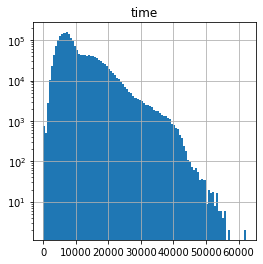

In [35]:
# Time distribution
sm.pt_los.hist(column='time', bins=100, figsize=(4,4), log=True)

array([[<AxesSubplot:title={'center':'ntransfers'}>]], dtype=object)

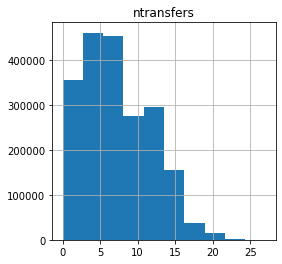

In [36]:
sm.pt_los.hist(column='ntransfers', figsize=(4,4))

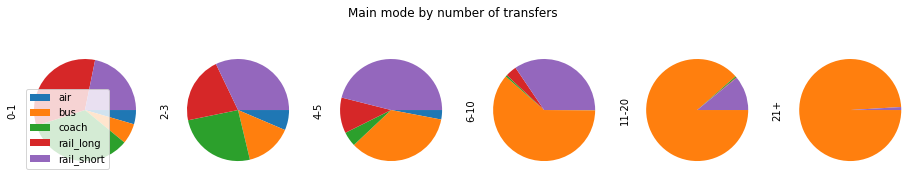

In [37]:
# Main mode distribution by transfers
t = sm.pt_los.copy()
t['bins'] = pd.cut(t['ntransfers'], bins=[0,1,3,5,10,20,100],
                   labels=["0-1", "2-3","4-5","6-10","11-20","21+"])
axs = t.groupby(['route_type','bins']).size().unstack(fill_value=0).plot.pie(
    subplots=True, figsize=(16, 3),
    startangle=0, counterclock=False, title='Main mode by number of transfers',
    legend=False, labeldistance=None)
axs[0].legend(loc='lower left')

<AxesSubplot:xlabel='route_types'>

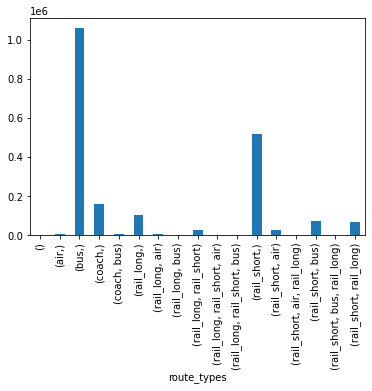

In [38]:
# Distribution of mode combinations
t['route_types'] = t['route_types'].apply(tuple)
t.groupby('route_types').count()['route_type'].plot(kind='bar')

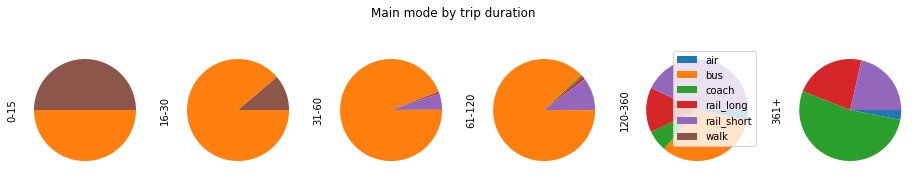

In [39]:
t['time'] = t['time'] / 60
t['bins'] = pd.cut(t['time'], bins=[0,15,30,60,120,360,500],
                   labels=["0-15", "16-30","31-60","61-120","120-360","361+"])
axs = t.groupby(['route_type','bins']).size().unstack(fill_value=0).plot.pie(
    subplots=True, figsize=(16, 3),
    startangle=0, counterclock=False, title='Main mode by trip duration',
    legend=False, labeldistance=None)
axs[3].legend()

In [40]:
t = None

In [41]:
# Drop unnecessary long connections if there is a waiting time applied
if sm.links['headway'].mean() > 5*60:
    sm.pt_los = sm.pt_los.loc[sm.pt_los['ntransfers']<=10]
    print(sm.pt_los.shape)
    # Drop coach connections with more than one transfer
    sm.pt_los = sm.pt_los.loc[~((sm.pt_los['route_type']=='coach') &
                                (sm.pt_los['boardings'].apply(
                                    lambda l: len([n for n in l if n.startswith('coach')])>2)
                                ))]
    print(sm.pt_los.shape)

(1545292, 31)
(1445564, 31)


In [42]:
# Keep only the fastest trip(s)
sm.pt_los['route_types'] = sm.pt_los['route_types'].apply(tuple)
sm.pt_los = sm.pt_los.sort_values('time').groupby(
    ['origin', 'destination', 'route_types']).nth([0, 1]).reset_index()
sm.pt_los.shape

(765631, 31)

<AxesSubplot:xlabel='route_types'>

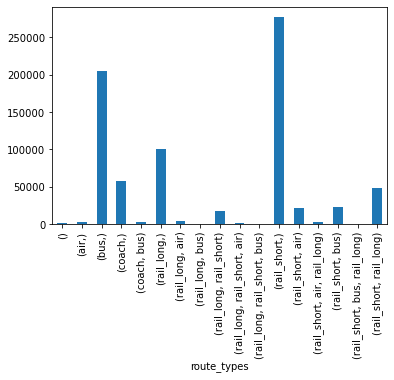

In [43]:
sm.pt_los.groupby('route_types').count()['route_type'].plot(kind='bar')

In [ ]:
# Berlin - Hamburg
all_pt_paths(sm, 'DE300', 'DE600', verbose=False, group_name='route_type')

### Save model

In [44]:
# Ditch unneccessary columns
to_drop = ['gtime', 'path', 'reversed', 'pathfinder_session',
           'broken_modes', 'boardings', 'alightings', 'node_path',
           'footpaths', 'ntlegs', 'transfers', 'boarding_links',
           'alighting_links', 'all_walk', 'time_link_path',
           'length_link_path', 'boarding_time', 'index']
sm.pt_los = sm.pt_los.drop(to_drop, axis=1, errors='ignore')

In [45]:
# Clean links table
to_drop = ['duration', 'cost', 'origin', 'destination']
sm.links = sm.links.drop(to_drop, axis=1, errors='ignore')

In [46]:
# Make table smaller
cols = ['time', 'access_time', 'in_vehicle_time', 'footpath_time',
        'waiting_time', 'length']
sm.pt_los[cols] = sm.pt_los[cols].astype(int)

In [47]:
sm.pt_los.sample()

,origin,destination,route_types,link_path,ntransfers,access_time,footpath_time,in_vehicle_time,waiting_time,time,price,length,route_type
699617,DEF03,DE24A,"(bus,)","[bus_602717, bus_2856219, bus_714240, bus_1814...",10,1524,0,1140,3300,5964,0,883530,bus


In [48]:
# Saving LoS...
sm.to_json(model_path + 'de_pt_los', only_attributes=['pt_los'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 35/35 [00:08<00:00,  4.17it/s]


In [49]:
# Split links in graph and auxiliary information
# for file sizes being compatible with github's size limit
cols = ['link_sequence', 'route_id', 'time', 'trip_id', 'length', 'headway']
auxiliary = sm.links[cols]
sm.links.drop(cols, axis=1, inplace=True)

In [50]:
sm.to_json(model_path + 'de_pt_network_agg', only_attributes=[
    'zones', 'links', 'nodes', 'pt_route_types'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 35/35 [00:27<00:00,  1.26it/s]


In [51]:
# Save auxiliary information seperately
auxiliary['index'] = auxiliary.index
auxiliary.reset_index(drop=True, inplace=True)
auxiliary.to_json(model_path + 'de_pt_network_agg/links_quetzaldata.json')